## Previous work

![Previous work](./previous_work.png "Previous work")

## Introduction 

My goal was to generate python functions, using only math, numpy and pure python, with a algorithm approche, simplicity and easy to port to C / C ++.
For each attention mask (a, b, c and d ), i have written the following features : 
- add a mask to a matrix wich zero out some value, based on the concerned parameter, 
- same, but based on a given sparsity
- generate artificial matrix of only ones and zero based on the mask
- a test function which shows how to use it and the output

## Code

#### Imports

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import math

## UTILS

In [136]:
def get_nb_non_zero(matrix):
    return np.count_nonzero(matrix)

In [137]:
def get_density(matrix, length):
    return float(get_nb_non_zero(matrix)) / float(length * length)

In [138]:
def get_sparsity(matrix, length):
    return 1.0 - get_density(matrix, length)

In [139]:
def show_matrix_infos(matrix, length):
    # conditions : shape(matrix) = (length, length)
    sparsity = get_sparsity(matrix, length)
    text = f"Given length : ({length}, {length}) and calculated length : {np.shape(matrix)} sparsity = {sparsity}"
    plt.title(label=text)
    plt.imshow(matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.show()

## RANDOM ATTENTION

### By number of non-zeros per row

In [140]:
def add_random_attention_mask(matrix, length, nz_per_row):
    # conditions : shape(matrix) = (length, length), nz_per_row <= length
    res = matrix.copy()
    z_per_row = length - nz_per_row 
    masked_indices = []
    for row in range(length):
        column_indices = np.random.choice(a=length, size=z_per_row ,replace= False)
        for col in column_indices:
            masked_indices.append((row,int(col)))
    for mi in masked_indices:
        res[mi] = 0
    return res

In [141]:
def generate_matrix_with_random_attention_mask(length, nz_per_row):
    # conditions : nz_per_row <= length
    matrix = np.ones((length, length))
    matrix = add_random_attention_mask(matrix=matrix, length=length, nz_per_row=nz_per_row)
    return matrix

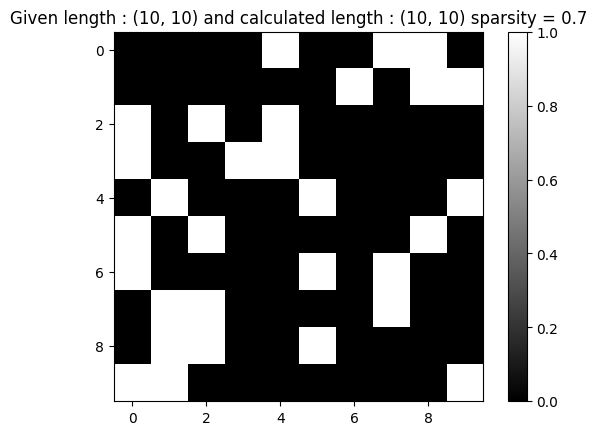

In [142]:
def test_generate_matrix_with_random_attention_mask():
    length = 10
    nz_per_row = 3
    matrix = generate_matrix_with_random_attention_mask(length=length, nz_per_row=nz_per_row)
    show_matrix_infos(matrix=matrix, length=length)

test_generate_matrix_with_random_attention_mask()

### By sparsity

In [143]:
def sparsity_to_nz_per_row(length, sparsity):
    # conditions : 0 <= sparsity <= 1
    return round(length * (1 - sparsity))

In [144]:
def add_random_attention_mask_with_sparsity(matrix, length, sparsity):
    # conditions : 0 <= sparsity <= 1
    nz_per_row=sparsity_to_nz_per_row(length=length, sparsity=sparsity)
    return add_random_attention_mask(matrix=matrix, length=length, nz_per_row=nz_per_row)

In [145]:
def generate_matrix_with_random_attention_mask_with_sparsity(length, sparsity):
    # conditions : 0 <= sparsity <= 1
    matrix = np.ones((length, length))
    matrix = add_random_attention_mask_with_sparsity(matrix=matrix, length=length, sparsity= sparsity)
    return matrix

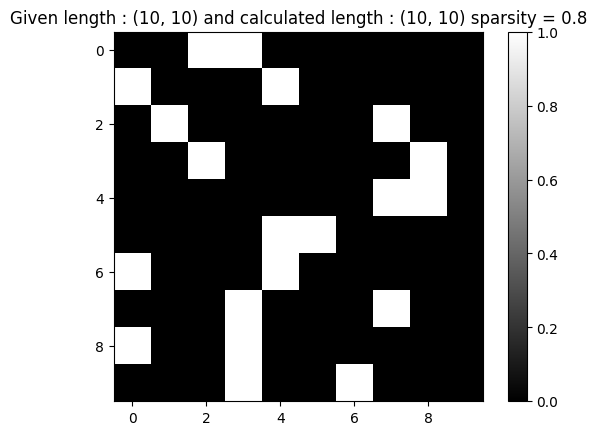

In [146]:
def test_generate_matrix_with_random_attention_mask_with_sparsity():
    length = 10
    sparsity = 0.8
    matrix = generate_matrix_with_random_attention_mask_with_sparsity(length=length, sparsity=sparsity)
    show_matrix_infos(matrix=matrix, length=length)

test_generate_matrix_with_random_attention_mask_with_sparsity()

## WINDOW ATTENTION

![Tridiagonal matrix Image](tridiagonal_matrix.png "Tridiagonal matrix")

### Utils

In [147]:
def diagonal_area(length,diagonal_width):
    # conditions : length
    if(diagonal_width == 0):
        return 0
    else:
        n = length
        #semi diagonal widht
        sdw = diagonal_width // 2 # (diagonal_width / 2 - 1 because is odd)
        da = n * ( 1 + 2 * sdw ) - sdw * (sdw + 1)
        return da

### By diagonal width

In [148]:
def add_window_attention_mask(matrix, length, diagonal_width):
    # conditions : shape(matrix) = (length, length), 0 <= diagonal_width <= 2*length - 1 (cover full matrix), diagonal_width is odd
    res = matrix.copy()
    if (diagonal_width > 0):
        mask = np.zeros(shape=(length, length), dtype=bool)
        if(diagonal_width == 1):
            mask[np.diag_indices(length)] = True
        else:
            #semi diagonal widht
            sdw = diagonal_width // 2 # (diagonal_width / 2 - 1 because is odd)
            for i in range(length):
                for j in range(max(0, i-sdw), min(length, i+sdw+1)):
                    mask[i,j] = True
        res[~mask] = 0             
    return res
    

In [149]:
def generate_matrix_with_window_attention_mask(length, diagonal_width):
    # conditions :  0 <= diagonal_width <= 2*length - 1 (cover full matrix), diagonal_width is odd
    matrix = np.ones((length, length))
    matrix = add_window_attention_mask(matrix=matrix, length= length, diagonal_width=diagonal_width)
    return matrix

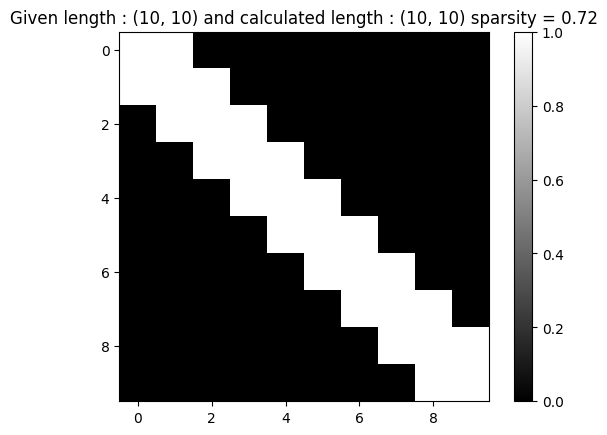

In [150]:
def test_generate_matrix_with_window_attention_mask():
    length = 10
    diagonal_width = 3
    matrix = generate_matrix_with_window_attention_mask(length=length, diagonal_width=diagonal_width)
    show_matrix_infos(matrix,length)

test_generate_matrix_with_window_attention_mask()

### By sparsity

In [151]:
def best_diagonal_width_from_sparsity(length, sparsity):
    n = length
    density = 1.0 - sparsity
     # ideal diagonal aera
    da = n * n * density
    # from this point, all is explained in the related document
    a = -1
    b = 2 * n - 1
    c = n - da
    det = b * b - 4 * a * c
    x = (-b + math.sqrt(det))/(2 * a)
    
    sdw = round(x)
    
    dw = 2 * sdw + 1
    
    if(dw < 0) : dw = 0
    elif(dw > 2*n - 1): dw = 2*n - 1
    # print(f"For matrix of size: {n} and given sparsity: {sparsity}, ideal semi diagonal width is : {x}, chosen dw is {dw}")
    return dw    

In [152]:
def test_diagonal_width_from_sparsity():
    for length in {10, 250, 900}:
        for sparsity in {0.1, 0.5, 0.88}:
            da = best_diagonal_width_from_sparsity(length, sparsity)
            real_sparsity = 1.0 - (float(diagonal_area(length,da))/float(length * length))
            print(f"for lenght={length}, given sparsity ={sparsity}, optimal diagonal width={da}, and real sparsity = {real_sparsity:.2f}")
            
test_diagonal_width_from_sparsity()

for lenght=10, given sparsity =0.1, optimal diagonal width=13, and real sparsity = 0.12
for lenght=10, given sparsity =0.5, optimal diagonal width=5, and real sparsity = 0.56
for lenght=10, given sparsity =0.88, optimal diagonal width=1, and real sparsity = 0.90
for lenght=250, given sparsity =0.1, optimal diagonal width=341, and real sparsity = 0.10
for lenght=250, given sparsity =0.5, optimal diagonal width=147, and real sparsity = 0.50
for lenght=250, given sparsity =0.88, optimal diagonal width=31, and real sparsity = 0.88
for lenght=900, given sparsity =0.1, optimal diagonal width=1231, and real sparsity = 0.10
for lenght=900, given sparsity =0.5, optimal diagonal width=527, and real sparsity = 0.50
for lenght=900, given sparsity =0.88, optimal diagonal width=111, and real sparsity = 0.88


In [153]:
def add_window_attention_mask_with_sparsity(matrix, length, sparsity):
    # conditions : 0 <= sparsity <= 1
    dw = best_diagonal_width_from_sparsity(length, sparsity)
    return add_window_attention_mask(matrix=matrix, length=length, diagonal_width=dw)

In [154]:
def generate_matrix_with_window_attention_mask_with_sparsity(length, sparsity):
    # conditions :  0 <= diagonal_width <= 2*length - 1 (cover full matrix), diagonal_width is odd
    matrix = np.ones((length, length))
    matrix = add_window_attention_mask_with_sparsity(matrix=matrix, length= length, sparsity=sparsity)
    return matrix

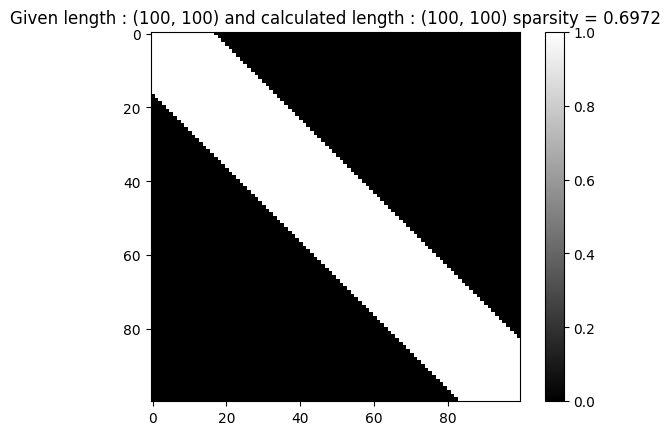

In [155]:
def test_generate_matrix_with_window_attention_mask_with_sparsity():
    length = 100
    sparsity = 0.7
    matrix = generate_matrix_with_window_attention_mask_with_sparsity(length=length, sparsity=sparsity)
    show_matrix_infos(matrix,length)

test_generate_matrix_with_window_attention_mask_with_sparsity()

# GLOBAL ATTENTION

### Utils

In [156]:
def global_attention_aera(length,global_attention_width):
    w = global_attention_width
    n = length
    return (2 * w * n) - (w * w)

print(global_attention_aera(10,2))

36


In [157]:
def add_global_attention_mask(matrix, length, global_width):
    res = matrix.copy()
    mask = np.zeros(shape=(length,length), dtype=bool)
    mask[:global_width,:] = True
    mask[global_width : , : global_width] = True
    res[~mask] = 0
    return res 

In [158]:
def generate_matrix_with_global_attention_mask(length, global_width):
    matrix = np.ones((length, length))
    matrix = add_global_attention_mask(matrix=matrix, length=length, global_width=global_width)
    return matrix

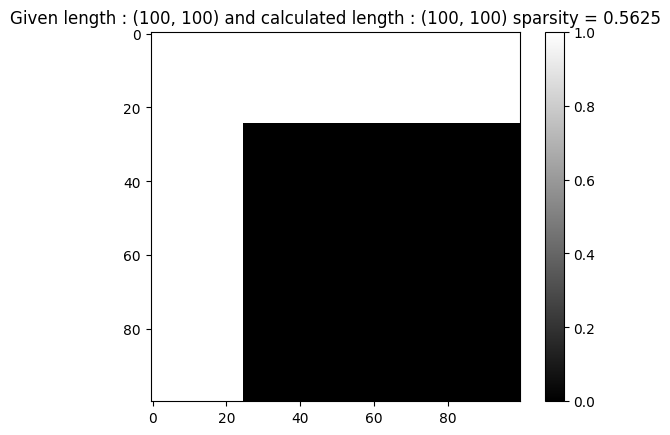

In [159]:
def test_generate_matrix_with_global_attention_mask():
    length = 100
    global_width = 25
    matrix = generate_matrix_with_global_attention_mask(length=length, global_width=global_width)
    show_matrix_infos(matrix=matrix, length=length)
    
test_generate_matrix_with_global_attention_mask()

In [160]:
def best_global_width_from_sparsity(length, sparsity):
    n = length
    density = 1.0 - sparsity
     # ideal diagonal aera
    ga = n * n * density
    # same as window mask but easier
    a = -1
    b = 2 * n
    c = - ga
    det = b * b - 4 * a * c
    x = (-b + math.sqrt(det))/(2 * a)
    gw = round(x)
    if(gw < 0) : gw = 0
    elif(gw > n * n ): gw = n * n
    return gw 

In [161]:
def test_global_width_from_sparsity():
    for length in {10, 250, 900}:
        for sparsity in {0.1, 0.5, 0.88}:
            ga = best_global_width_from_sparsity(length, sparsity)
            real_sparsity = 1.0 - (float(global_attention_aera(length,ga))/float(length * length))
            print(f"for lenght={length}, given sparsity ={sparsity}, optimal global width={ga}, and real sparsity = {real_sparsity:.2f}")
            
#test_global_width_from_sparsity()

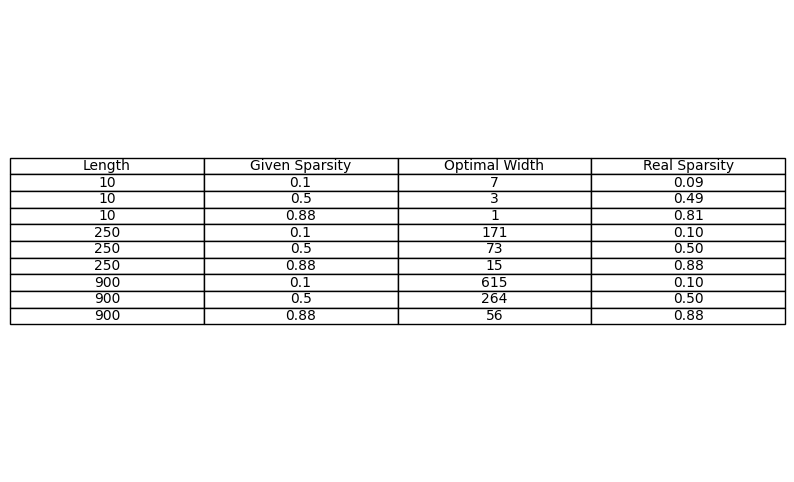

In [162]:
def test_global_width_from_sparsity():
    # Collecter les données
    data = []
    for length in {10, 250, 900}:
        for sparsity in {0.1, 0.5, 0.88}:
            ga = best_global_width_from_sparsity(length, sparsity)
            real_sparsity = 1.0 - (float(global_attention_aera(length,ga))/float(length * length))
            data.append([length, sparsity, ga, f"{real_sparsity:.2f}"])
    
    # Afficher le tableau
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(
        cellText=data,
        colLabels=['Length', 'Given Sparsity', 'Optimal Width', 'Real Sparsity'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    plt.show()
    
test_global_width_from_sparsity()

In [163]:
def add_global_attention_mask_with_sparsity(matrix, length, sparsity):
    # conditions : 0 <= sparsity <= 1
    gw = best_global_width_from_sparsity(length, sparsity)
    return add_global_attention_mask(matrix=matrix, length=length, global_width=gw)

In [164]:
def generate_matrix_with_global_attention_mask_with_sparsity(length, sparsity):
    matrix = np.ones((length, length))
    matrix = add_global_attention_mask_with_sparsity(matrix=matrix, length=length, sparsity=sparsity)
    return matrix

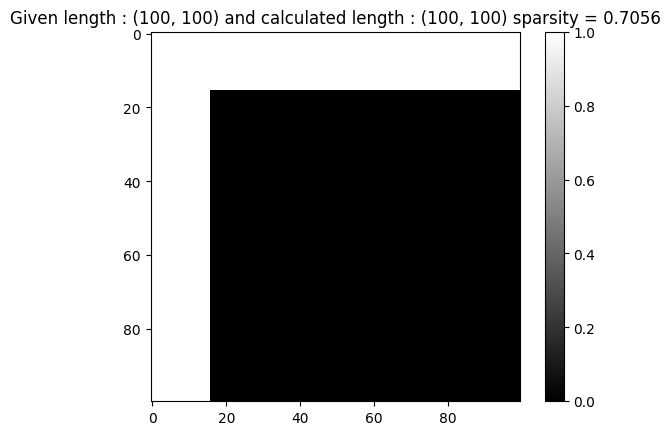

In [165]:
def test_generate_matrix_with_global_attention_mask_with_sparsity():
    length = 100
    sparsity = 0.7
    matrix = generate_matrix_with_global_attention_mask_with_sparsity(length=length, sparsity=sparsity)
    show_matrix_infos(matrix=matrix, length=length)
    
test_generate_matrix_with_global_attention_mask_with_sparsity()

## BIG BIRD (combination of all above)

In [166]:
def add_big_bird_mask(matrix, length, nz_per_row, diagonal_width, global_width):
    res = matrix.copy()
    matrix = add_random_attention_mask(matrix=matrix, length= length, nz_per_row=nz_per_row)
    matrix = add_window_attention_mask(matrix=matrix, diagonal_width=diagonal_width)
    matrix = add_global_attention_mask(matrix=matrix, length=length, global_width= global_width)
    return res